In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from fbprophet import Prophet
from pycaret.regression import *


import warnings
warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 11})
# import seaborn as sns

In [2]:
df = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2020-12-31.csv')

In [3]:
df.head(5)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.shape

(4727777, 8)

In [5]:
df.isna().sum() / df.shape[0] * 100

Timestamp             0.00000
Open                 26.30141
High                 26.30141
Low                  26.30141
Close                26.30141
Volume_(BTC)         26.30141
Volume_(Currency)    26.30141
Weighted_Price       26.30141
dtype: float64

In [6]:
print(f'Old size: {df.shape}')
df['Timestamp'] = [datetime.fromtimestamp(x) for x in df['Timestamp']]
df = df.set_index('Timestamp')
df = df.resample("24H").mean()
print(f'New size: {df.shape}')
df.head()

Old size: (4727777, 8)
New size: (3289, 7)


,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31,4.4650,4.482500,4.4650,4.482500,23.829470,106.330084,4.471603
2012-01-01,4.7100,4.710000,4.7100,4.710000,5.751000,27.639580,4.710000
2012-01-02,5.0000,5.000000,5.0000,5.000000,14.574000,72.870000,5.000000
2012-01-03,5.2525,5.252500,5.2525,5.252500,11.004660,58.100651,5.252500
2012-01-04,5.2000,5.223333,5.2000,5.223333,11.914807,63.119577,5.208159


In [7]:
df.isna().sum() / df.shape[0] * 100

Open                 0.091213
High                 0.091213
Low                  0.091213
Close                0.091213
Volume_(BTC)         0.091213
Volume_(Currency)    0.091213
Weighted_Price       0.091213
dtype: float64

In [8]:
df.fillna(method='ffill', inplace=True)
df.isna().sum() / df.shape[0] * 100

Open                 0.0
High                 0.0
Low                  0.0
Close                0.0
Volume_(BTC)         0.0
Volume_(Currency)    0.0
Weighted_Price       0.0
dtype: float64

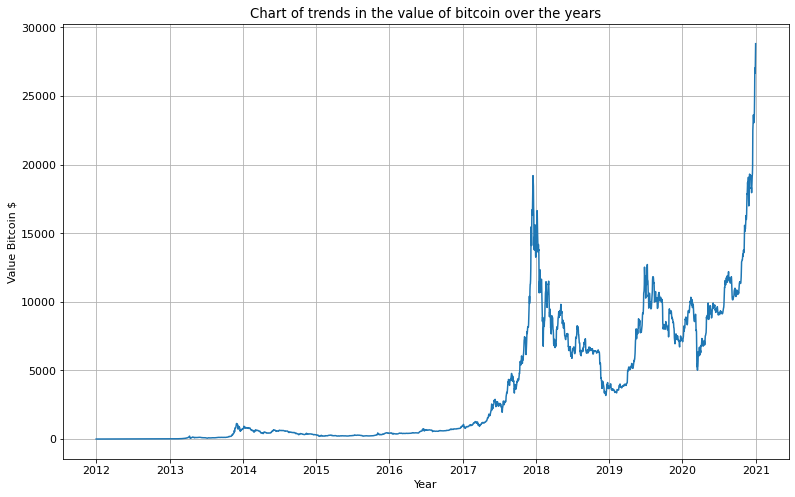

In [9]:
plt.figure(figsize=(13,8))
plt.plot(df['Weighted_Price']);
plt.xlabel('Year')
plt.ylabel('Value Bitcoin $')
plt.title('Chart of trends in the value of bitcoin over the years')
plt.grid()
plt.show()

In [10]:
df.reset_index(inplace=True)
prophet_df = df[['Timestamp', 'Weighted_Price']]
prophet_df.rename(columns={'Timestamp':'ds', 'Weighted_Price': 'y'}, inplace=True)

In [11]:
prophet_df.head()

,ds,y
0,2011-12-31,4.471603
1,2012-01-01,4.710000
2,2012-01-02,5.000000
3,2012-01-03,5.252500
4,2012-01-04,5.208159


In [12]:
proph = Prophet(daily_seasonality=True)

In [13]:
%%time
proph.fit(prophet_df[['ds', 'y']])

Wall time: 33.8 s


In [14]:
future = proph.make_future_dataframe(periods=730)
future.tail()

,ds
4014,2022-12-27
4015,2022-12-28
4016,2022-12-29
4017,2022-12-30
4018,2022-12-31


In [15]:
pred = proph.predict(future)

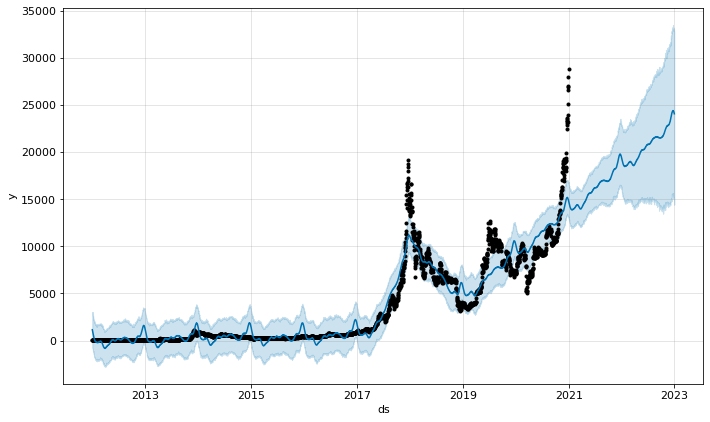

In [16]:
fig1 = proph.plot(pred)

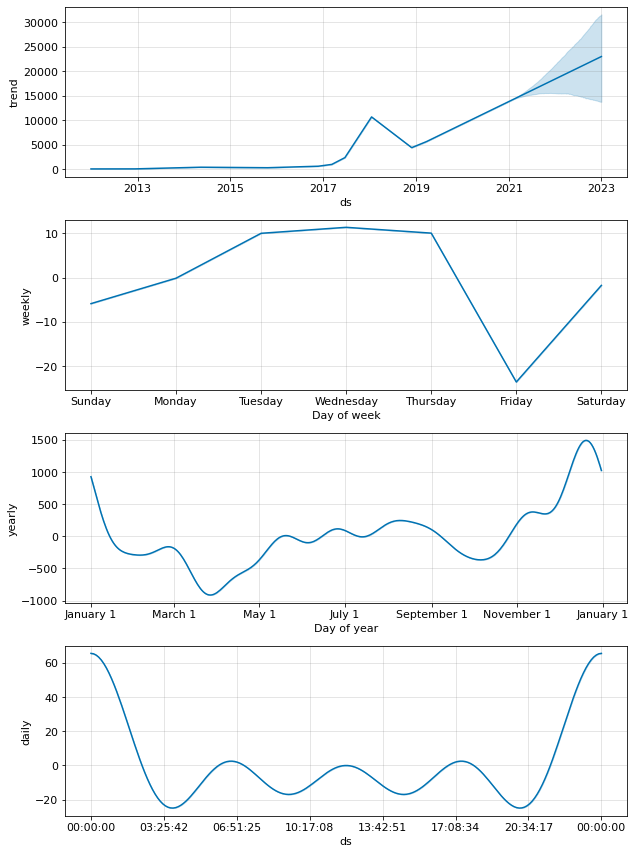

In [17]:
fig2 = proph.plot_components(pred);

In [18]:
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation

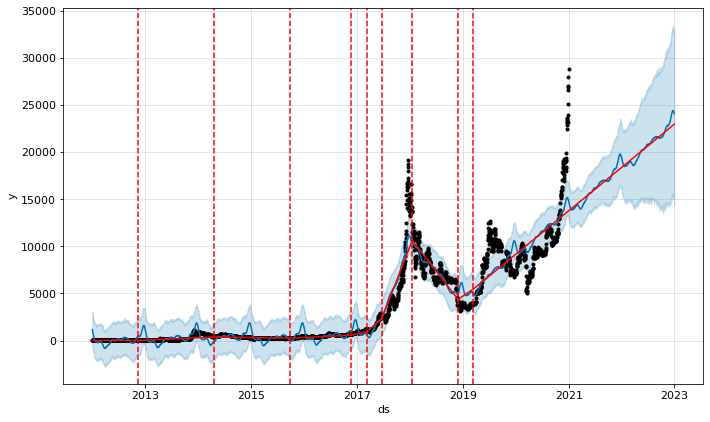

In [19]:
fig = proph.plot(pred);
a = add_changepoints_to_plot(fig.gca(), proph, pred);

In [20]:
df.columns.values

array(['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume_(BTC)',
       'Volume_(Currency)', 'Weighted_Price'], dtype=object)

In [21]:
prophet_df['Open'] = df['Open']
prophet_df['High'] = df['High']
prophet_df['Low'] = df['Low']
prophet_df['Close'] = df['Close']
prophet_df['Volume_(BTC)'] = df['Volume_(BTC)']
prophet_df['Volume_(Currency)'] = df['Volume_(Currency)']

In [22]:
prophet_df.head()

,ds,y,Open,High,Low,Close,Volume_(BTC),Volume_(Currency)
0,2011-12-31,4.471603,4.4650,4.482500,4.4650,4.482500,23.829470,106.330084
1,2012-01-01,4.710000,4.7100,4.710000,4.7100,4.710000,5.751000,27.639580
2,2012-01-02,5.000000,5.0000,5.000000,5.0000,5.000000,14.574000,72.870000
3,2012-01-03,5.252500,5.2525,5.252500,5.2525,5.252500,11.004660,58.100651
4,2012-01-04,5.208159,5.2000,5.223333,5.2000,5.223333,11.914807,63.119577


In [23]:
mult_proph = Prophet(daily_seasonality=True)

In [24]:
mult_proph.add_regressor('Open')
mult_proph.add_regressor('High')
mult_proph.add_regressor('Low')
mult_proph.add_regressor('Close')
mult_proph.add_regressor('Volume_(BTC)')
mult_proph.add_regressor('Volume_(Currency)')

X_train = prophet_df[:round(len(prophet_df) * 0.7)]
X_test = prophet_df[round(len(prophet_df) * 0.7):]

In [25]:
X_train.shape[0] + X_test.shape[0] == prophet_df.shape[0]

True

In [26]:
X_train.head()

,ds,y,Open,High,Low,Close,Volume_(BTC),Volume_(Currency)
0,2011-12-31,4.471603,4.4650,4.482500,4.4650,4.482500,23.829470,106.330084
1,2012-01-01,4.710000,4.7100,4.710000,4.7100,4.710000,5.751000,27.639580
2,2012-01-02,5.000000,5.0000,5.000000,5.0000,5.000000,14.574000,72.870000
3,2012-01-03,5.252500,5.2525,5.252500,5.2525,5.252500,11.004660,58.100651
4,2012-01-04,5.208159,5.2000,5.223333,5.2000,5.223333,11.914807,63.119577


In [27]:
%%time
mult_proph.fit(X_train)

Wall time: 1min 4s


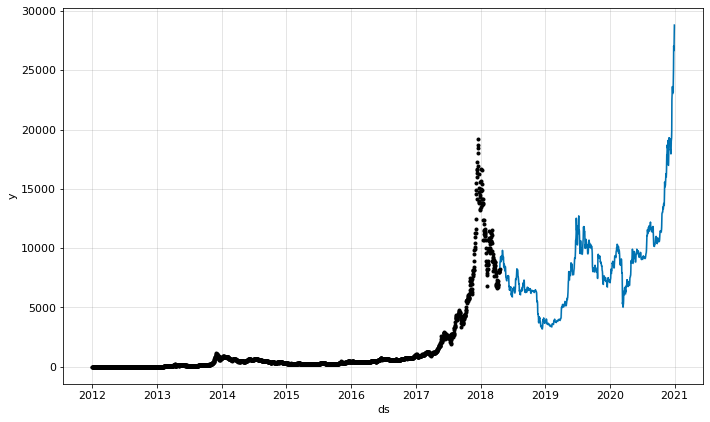

In [31]:
multy_pred = mult_proph.predict(X_test)
fig1 = mult_proph.plot(multy_pred)

In [44]:
df.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31,4.4650,4.482500,4.4650,4.482500,23.829470,106.330084,4.471603
2012-01-01,4.7100,4.710000,4.7100,4.710000,5.751000,27.639580,4.710000
2012-01-02,5.0000,5.000000,5.0000,5.000000,14.574000,72.870000,5.000000
2012-01-03,5.2525,5.252500,5.2525,5.252500,11.004660,58.100651,5.252500
2012-01-04,5.2000,5.223333,5.2000,5.223333,11.914807,63.119577,5.208159


In [47]:
%%time

reg1 = setup(data = df, target = 'Weighted_Price', silent=True, log_experiment=False, session_id=13)
best_model = compare_models(fold=5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,0.2261,0.2542,0.5035,1.0000,0.0014,0.0005,0.0340
omp,Orthogonal Matching Pursuit,0.2376,0.3029,0.5491,1.0000,0.0003,0.0002,0.0320
lasso,Lasso Regression,0.2476,0.2630,0.5120,1.0000,0.0025,0.0011,0.0140
par,Passive Aggressive Regressor,0.3679,0.5984,0.7619,1.0000,0.0019,0.0007,0.0200
br,Bayesian Ridge,0.2261,0.2542,0.5035,1.0000,0.0014,0.0005,0.0160
huber,Huber Regressor,0.2290,0.2593,0.5083,1.0000,0.0017,0.0006,0.0460
lar,Least Angle Regression,0.2261,0.2540,0.5033,1.0000,0.0015,0.0005,0.0120
en,Elastic Net,0.2378,0.2572,0.5063,1.0000,0.0017,0.0008,0.0280
ridge,Ridge Regression,0.2262,0.2541,0.5034,1.0000,0.0014,0.0005,0.0160
llar,Lasso Least Angle Regression,35.8706,1848.4863,42.9290,0.9999,0.5607,0.6096,0.0160


INFO:logs:create_model_container: 17
INFO:logs:master_model_container: 17
INFO:logs:display_container: 2
INFO:logs:LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)
INFO:logs:compare_models() succesfully completed......................................


Wall time: 14 s


In [48]:
lr = create_model('lr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.1868,0.2135,0.4621,1.0000,0.0015,0.0006
1,0.2258,0.2224,0.4716,1.0000,0.0011,0.0004
2,0.2390,0.2756,0.5249,1.0000,0.0012,0.0005
3,0.2419,0.2579,0.5078,1.0000,0.0008,0.0003
4,0.2483,0.3477,0.5897,1.0000,0.0007,0.0003
5,0.2082,0.2123,0.4607,1.0000,0.0025,0.0008
6,0.2252,0.2193,0.4683,1.0000,0.0015,0.0005
7,0.2303,0.2357,0.4855,1.0000,0.0020,0.0006
8,0.2416,0.3407,0.5837,1.0000,0.0012,0.0004
9,0.2111,0.2037,0.4513,1.0000,0.0013,0.0005


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 3
INFO:logs:LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)
INFO:logs:create_model() succesfully completed......................................


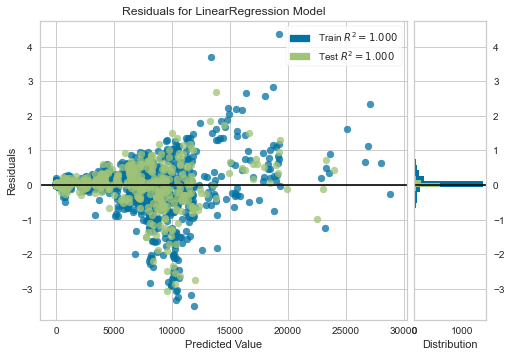

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [49]:
plot_model(lr)

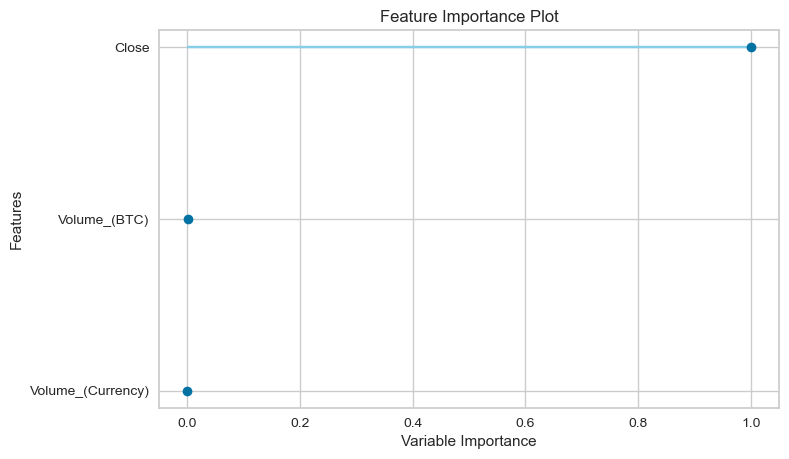

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [50]:
plot_model(lr, plot='feature')

In [53]:
best = automl(optimize = 'MAE')
best

INFO:logs:Initializing automl()
INFO:logs:automl(optimize=MAE, use_holdout=False)
INFO:logs:Model Selection Basis : CV Results on Training set
INFO:logs:Initializing create_model()
INFO:logs:create_model(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False), fold=None, round=4, cross_validation=False, predict=False, fit_kwargs=None, groups=None, refit=True, verbose=False, system=False, metrics=None, display=None, kwargs={})
INFO:logs:Checking exceptions
INFO:logs:Importing libraries
INFO:logs:Copying training dataset
INFO:logs:Defining folds
INFO:logs:Declaring metric variables
INFO:logs:Importing untrained model
INFO:logs:Declaring custom model
INFO:logs:Linear Regression Imported succesfully
INFO:logs:Cross validation set to False
INFO:logs:Fitting Model
INFO:logs:LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)
INFO:logs:create_models() succesfully completed......................................
INFO:logs:LinearRegressio

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [52]:
pred_holdouts = predict_model(lr)
pred_holdouts.head()

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False), probability_threshold=None, encoded_labels=True, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.REGRESSION, display=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,0.1949,0.1803,0.4246,1.0000,0.0013,0.0005


,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Label
0,248.149200,5.757297,1427.363281,248.148605,248.151871
1,5001.939941,15.598735,78196.757812,5001.892090,5001.596680
2,235.302139,23.419970,5505.804688,235.289337,235.305466
3,9199.682617,8.086326,74500.117188,9198.958008,9199.600586
4,12000.166992,26.840057,315276.812500,12001.024414,11998.266602


In [54]:
new_data = df.copy()
new_data.drop(['Weighted_Price'], axis=1, inplace=True)
new_pred = predict_model(best, data= new_data)
new_pred.head()

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False), probability_threshold=None, encoded_labels=True, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.REGRESSION, display=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Label
Timestamp,,,,,,,
2011-12-31,4.4650,4.482500,4.4650,4.482500,23.829470,106.330084,4.518419
2012-01-01,4.7100,4.710000,4.7100,4.710000,5.751000,27.639580,4.710159
2012-01-02,5.0000,5.000000,5.0000,5.000000,14.574000,72.870000,5.017578
2012-01-03,5.2525,5.252500,5.2525,5.252500,11.004660,58.100651,5.263023
2012-01-04,5.2000,5.223333,5.2000,5.223333,11.914807,63.119577,5.235647


In [55]:
save_model(best, model_name='best-model')

INFO:logs:Initializing save_model()
INFO:logs:save_model(model=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False), model_name=best-model, prep_pipe_=Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False, features_todrop=[],
                                      id_columns=[], ml_usecase='regression',
                                      numerical_features=[],
                                      target='Weighted_Price',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_...
                ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                ('binn', 'passthrou

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[],
                                       target='Weighted_Price',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_...
                 ('cluster_all', 'passthrough'),
                 ('dummy', Dummify(target='Weighted_Price')),
                 ('fix_perfect', Remove_100(target='Weighted_Price')),
                 ('clean_names', Clean_Colum_Names()),
                 ('feature_select', '